# pre-requisites for Blind Delegated quantum computing (BDQC):

- In the literature, it is common to describe BDQC protocols in the MBQC paradigm, which is why readers need to check the Qiskit textbook for the MBQC tutorial first before proceeding further.
- This tutorial assumes basic knowledge of python, bitwise operations and numpy.

# Formal defintion of Blind Delegated quantum computing (BDQC):

The keyword here is **Blindness**: At the end of the protocol, the server gains no information at all about Alice’s input nor the computation.

There are various protocols to achieve this, some of them assume Alice can perform quantum measurement at the end but cannot prepare qubits (referred to as receive-and-measure), but we will focus on what is known as prepare-and-send Blind delegated quantum computing.

## Description Of the protocol

### Phase 1: preparation phase

Instead of preparing the resource in the $|+\rangle^{\otimes n} $ state for all qubits like we do in MBQC, Alice applies on each qubit $i$ a local random phase shift $\theta_i$ choosen randomly from $\{ 0, \frac{\pi}{4},\frac{2\pi}{4},..., \frac{7\pi}{4} \}$.

Therefore the state for each qubit becomes $ |{+_{\theta_i} }\rangle= \frac{ |{0}\rangle+e^{i\theta_i } |{1}\rangle }{\sqrt{2}} $

![Scheme of phase 1 of BDQC](images/phase1.png)

The value of the local phase shift $\theta_{i \in \{0...n\}}$ must remain secret only known to Alice. Thanks to this local phase shift, the input state is hidden from the server
### Phase 2: interaction phase

* For each qubit *i* in the cluster:
	
	1. **A:** Select measurement Basis $B_i$ in $ \{ |+_{\delta_i}  \rangle , |-_{\delta_i}   \rangle \}$
		- $ {\delta_i} = {\theta_i} + \pi r_i + \text{computation } {\phi_i}$
		- With $r_i$ <- random in $\{0,1\}$ and kept secret
	2. **A → B:**  Measure qubit i in basis $B_i$
	3. **B → A:**  Outcome of measurement on qubit $i$ as $m_i$
	4. **A:** De-randomize $m_i$ by flipping it if $r_i$=1
	5. **A:** adapts $B_{i+1}$ based on $m_i$'s real correction value and add the pauli corrections needed accordingly.


## Security of the protocol:
**Input Blindness**: is achieved by shifting the input states arbitrarily with a local hidden phase and “correcting” it later by adapting the measurement basis.

**Output Blindness**: is achieved by shifting the measurement angle by $r_i \pi$ at random. Therefore when the server returns the value, it won't know what it was supposed to be.

## Correctness of the protocol:
The correctness holds, based on MBQC proporties, the rotation in step 1 commutes with CZ and does not affect the global state. Only phase of each qubit locally changes, and that phase modification is corrected later.
The $r_i \pi$ rotation accounts to a rotation around the Z axis, which is also corrected by the bitflip done on Alice's side, therefore obtaining the correct outcome.


# Implementing BDQC in Qiskit


## Naive implemenation and its issues
We will see in this section how to implement a BDQC protocol in Qiskit, for that we will go through the challenge of realizing this implementation, we will see the possible issues and we will explore a technique to workaround these issues to achieve our goal.

The idea here is to implement the protocol as seen in the MBQC tutorial, but we will add local phase shifts (using p gate) to hide the states.

So let's take the identity cluster from the MBQC tutorial, and try to naively add the phase shifts and see if that is correct or not...

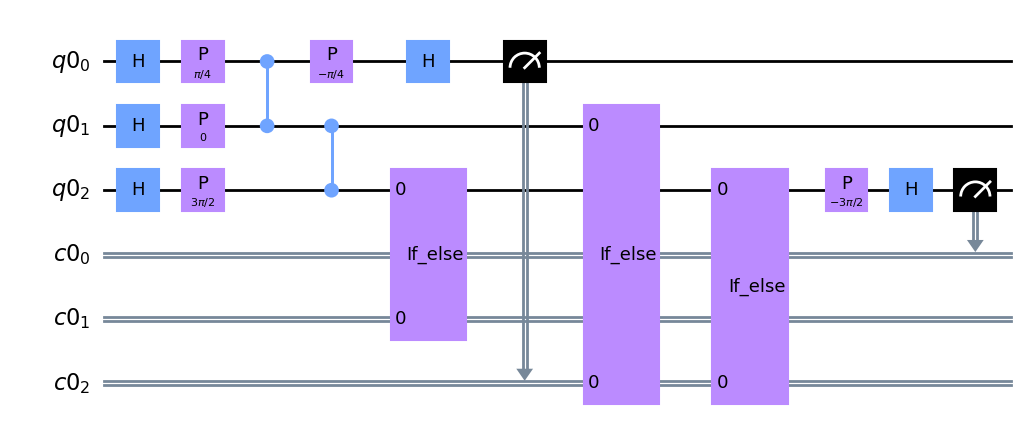

In [1]:
from qiskit import *
import numpy as np
# A WRONG NON-blind impelementation
nb_reg=3
q = QuantumRegister(nb_reg)
c = ClassicalRegister(nb_reg) # Changed from 9 to 1
qc = QuantumCircuit(q, c)


## The following individual variables are kept secret (by Alice) from the server
#8
A_hidden_phase= np.random.randint(8, size=(nb_reg)) #between 0 and 7 we will mulptiply by pi/4 later
computation_angle=[0,0,0] # the computation here is simple teleportation, so angles are 0
# 2
random_r = np.random.randint(1, size=(nb_reg)) # 

#### Phase 1: preparation phase

# Alice prepares |+++> state
for i in range(nb_reg):
    qc.h(i)
    qc.p(A_hidden_phase[i] *np.pi/4 ,i)

# Then send the state to the server + send classical instructions for entanglements order
# The server appliez  CZ(1,2)CZ(2,3 on the state recieved as instructed.
for i in range(nb_reg-1):
    qc.cz(i,i+1)

####END Phase 1: preparation phase


##########Measurement
def x_measurement(qbit:int):
    # the function meausures the MSB as the bit on the left (for consistency with the litterature, as opposed to usual order in qiskit)
    # Measurement is done in the X basis, i.e Hadamard before measurement

    qc.h(qbit)
    qc.measure(q[qbit],c[nb_reg-1-qbit])


####Phase 2: interaction and sequentiel measurement
qb=0
delta=  computation_angle[qb] - (A_hidden_phase[qb] *np.pi/4)  -  (random_r[qb]  *np.pi)
qc.p(delta ,qb)
x_measurement(qb)

#qubit 0 will give X correction if =1 to qubit 1
with qc.if_test((c[nb_reg-1-(0)], 1)):
    qc.x(1)        



#qubit 1 will give X correction if =1 to qubit 2
with qc.if_test((c[nb_reg-1-(1)], 1)):
    qc.x(2)

#qubit 0 will give Z correction if =1 to qubit 2
with qc.if_test((c[nb_reg-1-(0)], 1)):
    qc.z(2)        


qb=2
delta=  computation_angle[qb] - (A_hidden_phase[qb] *np.pi/4)  -  (random_r[qb]  *np.pi)
qc.p(delta ,qb)
x_measurement(qb)

qc.draw(output="mpl")


In [2]:
### Running the simulator to obtain measurement outcome
simulator = Aer.get_backend('aer_simulator_statevector') #qasm simulator
transpiled_circuit = transpile(qc, simulator)
job = execute(qc,simulator,shots = 10000)
result = job.result()
counts = result.get_counts(qc)
print(counts)


{'000': 5069, '100': 4931}


As you may have noticed the above implementation works in the sense that we teleport a `0` in the end. But, what we get in the end is not the same 4 outcomes we saw in the MBQC tutorial even though it is supposed to be the same computation, just with blindness. So, this should be a sign that something might be wrong.

Also, there is a major flaw, we are doing the MBQC correction separetly from the unblinding and the random $r_i\pi$ rotation. This means that we are leaking to the server the real value of the previous qubit based on the corrected outcome and the choosen correction. What we have to do in order to perform step 5 correctly is to adapt the measurement basis by including the MBQC correction in it, i.e modify the computation value $\phi_{i+1}$ instead of doing X and Z operations separately.

So the scheme will be something like this
- if $res_i$ := measurement($\text{qubit}_i$)=1 (returned by the server)
    - check $r_i$  if it was 1, then outcome is actually 0, do nothing
    - if $r_i$  if it was 0, then outcome is actually 1, 
        - do X correction on successor by classically controlled rotation with the X correction integrated in the angle (i.e +pi)
        - do Z correction on neighbors of successor by classically controlled rotation with the X correction integrated in the angle (i.e ??)
- if $res_i$ := measurement($\text{qubit}_i$)=0
    - same as if $res_i$ =1 above but switch the cases.

Here is an illustration of the steps to better understand:

Alice sends $\delta_1$ which is one value summing everything so that the server does not know the single values of blindness angle, random flip, nor the computation.

![Scheme of phase 2 of BDQC - measuring qubit 1](images/bdqc-interaction1.png)

After measuring the first qubit Alice gets back the measurement outcome, and adapts the computation angle to account for the correction needed for the affected qubits (2 and 3).

Alice then proceeds to measurng the 2nd qubit.

![Scheme of phase 2 of BDQC - measuring qubit 2](images/bdqc-interaction2.png)


After measuring the second qubit Alice gets back the measurement outcome, and adapts the computation angle to account for the correction needed for the affected qubits (3).

Alice then proceeds to measurng the 3rd qubit.

![Scheme of phase 2 of BDQC - measuring qubit 3](images/bdqc-interaction3.png)

You can see in this scheme that we can find how to adapt $\delta_3$'s value only when we reach it, and the value depends on qubits 1 and 2, measured each separately.

So, the limitation with the classical conditional flow in Qiskit is that we have to apply the controlled operation on the spot, which is not what we want, we need to actually measure single qubits sequentially and keep cumulating the corrections while remaining on the same shot/outcome. Qiskit does not allow you to modify your circuit mid-shot, once you transpile and request a shot, the circuit can't be modified.


## Workaround to achieve blindness

The good news is, while we cannot exactly implement the protocol as is, there is a workaround: we will perform a classical post-processing on Alice's side simulating the effects of X and Z correction on the final outcome.

**The effect of Z correction:**
When we apply a Z on one of our qubits in the cluster what happens is that it flips the bit we obtain in the outcome. The reason behind this is simple.
Our cluster is made of $|+_{\theta_i} \rangle ^{\otimes n}$, Z does the following: $Z|+ \rangle =|-_{\theta} \rangle $, which is why when we measure in X-basis (apply a Hadamard before measuring in computational basis) we translate the $|+\rangle$ and $|-\rangle$ to to $|0\rangle$ and $|1\rangle$ (respectively) and therefore  it equates to a bit flip.

**The effect of X correction:**
The effect of X correction is a bit more sensible to see because: $X|+_{\theta} \rangle =|+_{\theta} \rangle $, So we can ignore X correction usually, the only exception is if the computation $\phi_i$ we are performing equates to a 90° degrees rotation around the Z-axis, which means the computation angle is  $\pm \pi$/2 (i.e an $S$ or $S^{\dagger}$ operator), in this particular case, the effect of an X will equate to a Z, which therefore means the classical output we get should be flipped.



Now let's adapt the previous code for this.

we are going to replace the interactions by 1 single interaction, with all angles passed at once and we will perform a parallel measurement on all qubits instead of measuring sequentially and adapting the measurement basis mid-computation.


The 4 possible outcomes will be corrected as follows:

![before and after classical post-processing](images/before-after-correction.png)

Reminder: In case you are wondering about the order for corrections, it is based on the flow explained in the MBQC tutorial.

And Here is the code:

In [3]:
from qiskit import *
import numpy as np

nb_reg=3
q = QuantumRegister(nb_reg)
c = ClassicalRegister(nb_reg) # Changed from 9 to 1
qc = QuantumCircuit(q, c)


## The following individual variables are kept secret (by Alice) from the server
A_hidden_phase= np.random.randint(8, size=(nb_reg)) #between 0 and 7 we will mulptiply by pi/4 later
computation_angle=[0]*nb_reg # the computation here is simple teleportation, so angles are 0
random_r = np.random.randint(2, size=(nb_reg)) # 


#### Phase 1: preparation phase

# Alice prepares |+++> state
for i in range(nb_reg):
    qc.h(i)
    qc.p(A_hidden_phase[i] *np.pi/4 ,i)

# Then send the state to the server + send classical instructions for entanglements order
# The server appliez  CZ(1,2)CZ(2,3 on the state recieved as instructed.
for i in range(nb_reg-1):
    qc.cz(i,i+1)

####END Phase 1: preparation phase


##########Measurement
def x_measurement(qbit:int):
    # the function meausures the MSB as the bit on the left (for consistency with the litterature, as opposed to usual order in qiskit)
    # Measurement is done in the X basis, i.e Hadamard before measurement
    qc.h(qbit)
    qc.measure(q[qbit],c[nb_reg-1-qbit])



####Phase 2: interaction and sequentiel measurement is replaced 

for qb in range(nb_reg):
    # Delta as a whole is passed to the server, individual values are kept secret
    delta=  computation_angle[qb] - (A_hidden_phase[qb] *np.pi/4)  -  (random_r[qb]  *np.pi)
    qc.p(delta ,qb)
    x_measurement(qb)


print(qc.draw())
qc.draw(output="mpl")
### Running the simulator to obtain measurement outcome
simulator = Aer.get_backend('aer_simulator_statevector') #qasm simulator
transpiled_circuit = transpile(qc, simulator)
job = execute(qc,simulator,shots = 10000)
result = job.result()
counts = result.get_counts(qc)
print(counts)

### Byproduct correction by classical post-processing 
def byproduct_corr (outcome):
    x_correction =[0]*nb_reg
    z_correction =[0]*nb_reg
    
    # compute the corrections
    for qb in range(nb_reg-1): # -1 because the last qubit will not create any correction as it has no successors to correct
        if computation_angle[qb+1] == np.pi/2 or computation_angle[qb+1] == np.pi/2 :
            x_correction[qb+1] ^= outcome[qb]
            
        if qb<nb_reg-2: 
            z_correction[qb+2] ^= outcome[qb]

    z_corrected=np.bitwise_xor(outcome,z_correction)
    return np.bitwise_xor(z_corrected,x_correction)

for outcome,freq in counts.items():
    outcome_int =[int(i) for i in list(outcome)]
    # de-randomize
    outcome_derandomized=np.bitwise_xor(outcome_int,random_r)
    # Correct MBQC by-product
    outcome_corrected=byproduct_corr(outcome_derandomized)
    print("corrected",outcome_corrected, ":", freq)


       ┌───┐  ┌──────┐    ┌───────┐    ┌───┐    ┌─┐           
q23_0: ┤ H ├──┤ P(π) ├──■─┤ P(-π) ├────┤ H ├────┤M├───────────
       ├───┤┌─┴──────┴┐ │ └───────┘ ┌──┴───┴───┐└╥┘┌───┐┌─┐   
q23_1: ┤ H ├┤ P(3π/2) ├─■─────■─────┤ P(-5π/2) ├─╫─┤ H ├┤M├───
       ├───┤├─────────┤       │    ┌┴──────────┤ ║ ├───┤└╥┘┌─┐
q23_2: ┤ H ├┤ P(7π/4) ├───────■────┤ P(-11π/4) ├─╫─┤ H ├─╫─┤M├
       └───┘└─────────┘            └───────────┘ ║ └───┘ ║ └╥┘
 c1: 3/══════════════════════════════════════════╩═══════╩══╩═
                                                 2       1  0 
{'100': 2492, '110': 2518, '001': 2549, '011': 2441}
corrected [1 1 0] : 2492
corrected [1 0 0] : 2518
corrected [0 1 0] : 2549
corrected [0 0 0] : 2441


Finally, we can now see that the outcomes we obtain for this implementation BDQC are the same as if we run the MBQC computation without blindness.

Addionally, we can see that there is no clear pattern that may allow the server to deduce the corrected value from what they output to the client.

The server saw

{'100': 2492, '110': 2518, '001': 2549, '011': 2441}

But thanks to the the hidden values only the client knows how to reverse by-product and randomization to get:

{'110': 2492, '100': 2518, '010': 2549, '000': 2441}


You may now wonder, why do we bother describing the protocols in terms of feed-forward if we can just do classical post-processing?

The answers is: The approach presented above, works, but there is a caveat. It only works for clifford operations, which are indeed operations that can be simulation efficiently on a classical computer. Clifford operations are not universal (enough to perform all quantum computations).So they need to be complemented by a T gate for universality.

If a T gate is needed in the computation we are implementing then built-in support (at the level of the physical hardware) for feed-forward mid-measurement is required.



# Exercises for curious readers:

This tutorial showed a simple BDQC implementation on a 1D linear cluster, but this code can be re-used for more advanced cases.

Few exercises left to readers:

1. Adapt the above code as a generic protocols that takes a 2D cluster state of size $n \times m$ and loops through the 2 dimensions (layers-by-layer, and row-by-row inside each layer).

2. Another possible extension is to re-implement MBQC Hadamard or MBQC cnot from MBQC tutorial but with Blindness.

3. Implement blind grover from [[2]](https://arxiv.org/abs/0807.4154) with the classical post-processing technique shown above.

# References

[1] Universal blind quantum computation, A Broadbent, J. Fitzsimons, and E. Kashefi, arXiv:0807.4154 

[2] Experimental Demonstration of Blind Quantum Computing, S. Barz, E. Kashefi, et al, arXiv:1110.1381 

In [4]:
import qiskit.tools.jupyter

%qiskit_version_table